Here, we create a multiclass classifier for classifying the various closest vectors returned by the model, as the corresponding attributes.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.text
from keras.models import load_model
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Prepare Dataset

In [2]:
df = pd.read_csv('CleanHospitalDataset.csv', encoding='utf8', dtype=object)

In [3]:
df.head()

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,label
0,10010.0,MARSHALL MEDICAL CENTER NORTH,8000 ALABAMA HIGHWAY 69,GUNTERSVILLE,AL,35976.0,MARSHALL,2565718000.0,Acute Care Hospitals,1.0
1,10018.0,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233.0,JEFFERSON,2053258100.0,Acute Care Hospitals,1.0
2,10005.0,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957.0,MARSHALL,2565938310.0,Acute Care Hospitals,1.0
3,10025.0,G H LANIER MEMORIAL HOSPITAL,4800 48TH ST,VALLEY,AL,36854.0,CHAMBERS,3347561400.0,Acute Care Hospitals,1.0
4,10045.0,FAYETTE MEDICAL CENTER,1653 TEMPLE AVENUE NORTH,FAYETTE,AL,35555.0,FAYETTE,2059325966.0,Acute Care Hospitals,1.0


In [4]:
len(df)

1000

In [5]:
df.columns.values

array(['ProviderNumber', 'HospitalName', 'Address1', 'City', 'State',
       'ZipCode', 'CountyName', 'PhoneNumber', 'HospitalType', 'label'],
      dtype=object)

## Data Cleaning

In [6]:
df.drop(columns=['HospitalType','label','State'], axis=1, inplace=True)

In [7]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber
0,10010.0,MARSHALL MEDICAL CENTER NORTH,8000 ALABAMA HIGHWAY 69,GUNTERSVILLE,35976.0,MARSHALL,2565718000.0
1,10018.0,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233.0,JEFFERSON,2053258100.0


In [8]:
df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: str(int(float(x))))
df['ZipCode'] = df['ZipCode'].apply(lambda x: str(int(float(x))))
df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: str(int(float(x))))

In [9]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber
0,10010,MARSHALL MEDICAL CENTER NORTH,8000 ALABAMA HIGHWAY 69,GUNTERSVILLE,35976,MARSHALL,2565718000
1,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100


In [10]:
ProviderNumber = df['ProviderNumber'].tolist()
HospitalName = df['HospitalName'].tolist()
Address1 = df['Address1'].tolist()
City = df['City'].tolist()
ZipCode = df['ZipCode'].tolist()
CountyName = df['CountyName'].tolist()
PhoneNumber = df['PhoneNumber'].tolist()

In [11]:
values = [ProviderNumber, HospitalName, Address1, City, ZipCode, CountyName, PhoneNumber]
attributes = ['ProviderNumber', 'HospitalName', 'Address1', 'City','ZipCode','CountyName','PhoneNumber']

Create value, attribute-name tuple pairs

In [12]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([value, attributes[i]])

In [13]:
len(data)

7000

In [14]:
data[:10]

[['10010', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10005', 'ProviderNumber'],
 ['10025', 'ProviderNumber'],
 ['10045', 'ProviderNumber'],
 ['10022', 'ProviderNumber'],
 ['10008', 'ProviderNumber'],
 ['10009', 'ProviderNumber'],
 ['10044', 'ProviderNumber'],
 ['10008', 'ProviderNumber']]

In [15]:
data[-10:]

[['3342228466', 'PhoneNumber'],
 ['3347938701', 'PhoneNumber'],
 ['2567736511', 'PhoneNumber'],
 ['3343614267', 'PhoneNumber'],
 ['2567736511', 'PhoneNumber'],
 ['3343762205', 'PhoneNumber'],
 ['2565718000', 'PhoneNumber'],
 ['2054877736', 'PhoneNumber'],
 ['2563572111', 'PhoneNumber'],
 ['2562495000', 'PhoneNumber']]

In [16]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [17]:
dfData.head(2)

,Value,Label
0,10010,ProviderNumber
1,10018,ProviderNumber


In [18]:
dfData.tail()

,Value,Label
6995,3343762205,PhoneNumber
6996,2565718000,PhoneNumber
6997,2054877736,PhoneNumber
6998,2563572111,PhoneNumber
6999,2562495000,PhoneNumber


Convert labels to categorical attributes

In [19]:
dfData['Label'] = dfData['Label'].astype('category')

In [20]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [21]:
dfData.tail()

,Value,Label,Label_Cat
6995,3343762205,PhoneNumber,4
6996,2565718000,PhoneNumber,4
6997,2054877736,PhoneNumber,4
6998,2563572111,PhoneNumber,4
6999,2562495000,PhoneNumber,4


In [22]:
dfData['Label_Cat'].value_counts()

3    1000
6    1000
2    1000
5    1000
1    1000
4    1000
0    1000
Name: Label_Cat, dtype: int64

Get the mapping

In [23]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [24]:
mapping

{0: 'Address1',
 1: 'City',
 2: 'CountyName',
 3: 'HospitalName',
 4: 'PhoneNumber',
 5: 'ProviderNumber',
 6: 'ZipCode'}

Drop the Label column

In [25]:
dfData.drop(['Label'], axis=1, inplace=True)

In [26]:
dfData.head()

,Value,Label_Cat
0,10010,5
1,10018,5
2,10005,5
3,10025,5
4,10045,5


Shuffle the data

In [27]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [28]:
dfData.head(10)

,Value,Label_Cat
0,SHEFFIELD,1
1,10001,5
2,2000 PEPPERELL PARKWAY,0
3,35570,6
4,HAMILTON,1
5,10049,5
6,36854,6
7,36801,6
8,1653 TEMPLE AVENUE NORTH,0
9,OPELIKA,1


Find the longest string in the value column

In [29]:
dfData.Value.map(lambda x: len(str(x))).max()

36

In [30]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

## Tokenize and obtain the train, test split

In [31]:
batchSize = 32
maxSequenceLength = 40
maxWords = 25000

In [32]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 346 unique tokens.


In [33]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [34]:
labels = np.asarray(y)

In [35]:
data.shape

(7000, 40)

In [36]:
labels.shape

(7000,)

In [37]:
labels = to_categorical(labels)

In [38]:
labels.shape

(7000, 7)

Shuffle the dataset

In [39]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [40]:
data = data[indices]
labels = labels[indices]

## Train test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [42]:
len(X_train), len(y_train)

(5600, 5600)

In [43]:
len(X_test), len(y_test)

(1400, 1400)

## Model

In [44]:
embeddingDim = 100

**Architecture**
* 1 embedding layer 
* 1 dense layer, 32 hidden units and _relu_ activation
* 1 dense layer, 64 hidden units and _relu_ activation
* Output layer, _softmax_ activation

In [45]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(7, activation=activations.softmax))

model.compile(optimizer=optimizers.Adam(), loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           2500000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                128032    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 2,630,599
Trainable params: 2,630,599
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32, 
                    validation_split=0.2)

Train on 4480 samples, validate on 1120 samples
Epoch 1/5
4480/4480 [==============================] - 4s 903us/step - loss: 1.4644 - acc: 0.4167 - val_loss: 0.7913 - val_acc: 0.8527
Epoch 2/5
4480/4480 [==============================] - 2s 382us/step - loss: 0.2886 - acc: 0.9667 - val_loss: 0.0983 - val_acc: 0.9768
Epoch 3/5
4480/4480 [==============================] - 2s 374us/step - loss: 0.0623 - acc: 0.9779 - val_loss: 0.0460 - val_acc: 0.9812
Epoch 4/5
4480/4480 [==============================] - 2s 376us/step - loss: 0.0430 - acc: 0.9815 - val_loss: 0.0373 - val_acc: 0.9786
Epoch 5/5
4480/4480 [==============================] - 2s 379us/step - loss: 0.0406 - acc: 0.9786 - val_loss: 0.0375 - val_acc: 0.9777


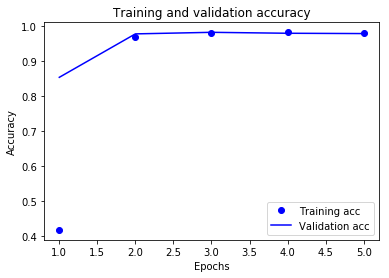

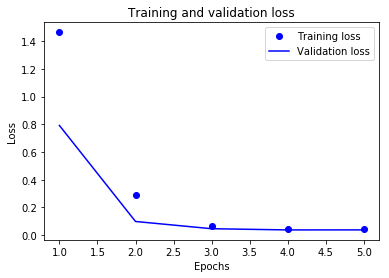

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [49]:
results = model.evaluate(X_test, y_test)

1400/1400 [==============================] - 0s 95us/step


In [50]:
loss = results[0]
accuracy = results[1]

In [51]:
loss

0.030701003868931105

In [52]:
accuracy

0.9821428571428571

Save the model

In [53]:
model.save("HospitalClassifier.h5")

Save the tokenizer

In [54]:
with open('HospitalAttributeClassifierTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Make predictions on new data

In [55]:
model = load_model('HospitalClassifier.h5')

In [56]:
with open('HospitalAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [57]:
testString = ['36278']

In [58]:
sequences = tokenizer.texts_to_sequences(testString)
testData = pad_sequences(sequences, maxlen=40)

In [59]:
predictions = model.predict(testData)

In [60]:
mapping[np.argmax(predictions[0])]

'ZipCode'